# <p style="text-align: center;">YOLOv8 Automatic Number Plate Recognition</p>

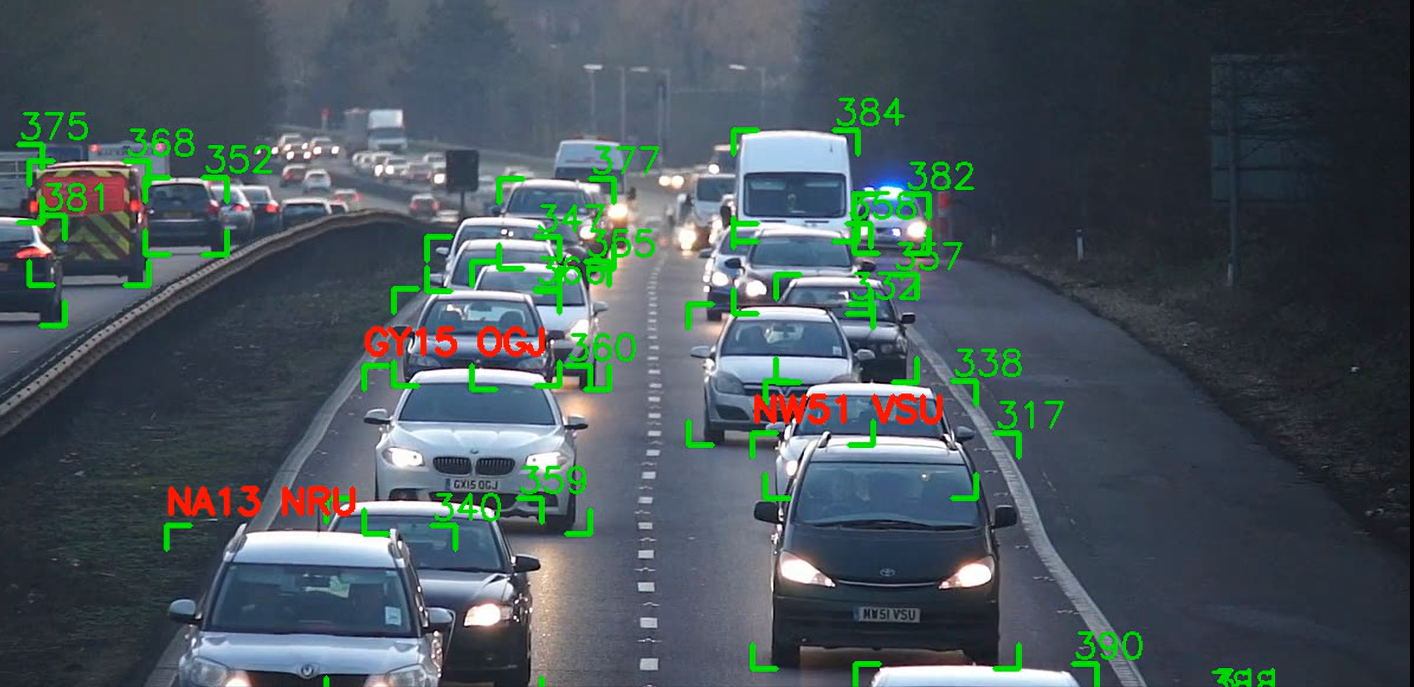

# Importing libraries

In [2]:
from IPython.display import Image
from util import *
import numpy as np
from sort.sort import *
import cv2
from ultralytics import YOLO

## Three Models used

* model to detect vehocles
* license_plate_detector to detect license plate
* plate_read to read the crop of license plate (trained on plates crop)

In [ ]:
model=YOLO("yolov8x.pt")
license_plate_detector=YOLO('plates_weight.pt')
plate_read=YOLO("last.pt")

In [3]:
# using Sort (Kalman filter) to track vehicles
mot_tracker = Sort()

In [4]:
# draw_border function to draw bboxes  put plate number text and vehicle track ID
def draw_border(img, top_left, bottom_right, color=(0, 255, 0), thickness=10, line_length_x=50, line_length_y=50,track_id=-1):
    x1, y1 = top_left
    x2, y2 = bottom_right

    cv2.line(img, (x1, y1), (x1, y1 + line_length_y), color, thickness)  #-- top-left
    cv2.line(img, (x1, y1), (x1 + line_length_x, y1), color, thickness)

    cv2.line(img, (x1, y2), (x1, y2 - line_length_y), color, thickness)  #-- bottom-left
    cv2.line(img, (x1, y2), (x1 + line_length_x, y2), color, thickness)

    cv2.line(img, (x2, y1), (x2 - line_length_x, y1), color, thickness)  #-- top-right
    cv2.line(img, (x2, y1), (x2, y1 + line_length_y), color, thickness)

    cv2.line(img, (x2, y2), (x2, y2 - line_length_y), color, thickness)  #-- bottom-right
    cv2.line(img, (x2, y2), (x2 - line_length_x, y2), color, thickness)
    
    cv2.putText(img, str(int(track_id)), (x2-20,y1-5), cv2.FONT_HERSHEY_SIMPLEX,  1, (0,250,0), 2)
    
    try:
        if track_id in car_dict:
            cv2.putText(img,car_dict[track_id], (int(x1),int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 250), 3)
    except:
        pass

    return img

In [14]:
# car_dict dictionary the keys are vehicles track ID and the values vehicles plate number
global car_dict
car_dict={}
video_path = "12.mp4"
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
   
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('filename1.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         25, size)
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run model inference on the frame
        results = model(frame,classes=[2, 3, 5, 7])
        
        # Run  license_plate_detector inference on the frame
        plate_detector_results=license_plate_detector(frame)
        
        detections=[]
        for detection in results[0].boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = detection
            detections.append([x1, y1, x2, y2, score])
            
        # Run Sort (kalman filter) on the model results
        track_ids = mot_tracker.update(np.asarray(detections))
        
        for id in track_ids:
            
            cx1, cy1, cx2, cy2, track_id = id
            draw_border(frame, (int(cx1), int(cy1)), (int(cx2), int(cy2)), (0, 255, 0), 3,
            line_length_x=20, line_length_y=20,track_id=track_id)
            
            

        for plate in plate_detector_results[0].boxes.data.tolist():
            px1, py1, px2, py2, pscore, pclass_id = plate
            
            # cropping the plates
            license_plate_crop = frame[int(py1):int(py2), int(px1): int(px2), :]
            
            # Run plate_read on plate crop
            plate_read_numbers=plate_read(license_plate_crop,conf=0.4)
            
            l=plate_read_numbers[0].boxes.data.tolist()
            
            # ordering the plate numbers depending on the bbox X1
            l.sort(key=lambda x: x[0])
            s=''
            g=[]
            for i,a in enumerate(l):
                g.append(l[i][0]-l[i-1][0])
                s+=labels[int(a[-1])]

            
            try:
                if license_complies_format(s):
                    s=format_license(s)
                    s=s[:4]+" "+s[4:]
                else:
                    s=''
                #s=s[:g.index(max(g))]+" "+s[g.index(max(g)):]
                
            except:
                pass

            # assign license plate to car
            xcar1, ycar1, xcar2, ycar2, car_id = get_car(plate, track_ids)

            if  car_id != -1:
                if len(s)==8:
                    car_dict[car_id]=s
            

        # Visualize the results on the frame
        annotated_frame = cv2.resize(frame, (1280, 720))
        result.write(annotated_frame)

        # Display the annotated frame
        cv2.imshow("car", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window

cap.release()
result.release()
cv2.destroyAllWindows()


0: 384x640 17 cars, 1 bus, 7 trucks, 142.2ms
Speed: 8.5ms preprocess, 142.2ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 11.0ms
Speed: 2.5ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 10.5ms
Speed: 1.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 K, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 7.5ms
Speed: 1.0ms preprocess, 7.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 1 bus, 7 trucks, 13.3ms
Speed: 1.0ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 2.4ms
Speed: 1.0ms preprocess, 2.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 2

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 4 trucks, 13.1ms
Speed: 0.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 N, 1 U, 1 V, 1 W, 1 1, 2 5s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 M, 1 N, 1 R, 1 U, 1 1, 1 3, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 4 trucks, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 3.5ms
Speed: 1.0ms preprocess, 3.


0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 256x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 2 Gs, 1 J, 1 Y, 1 1, 1 5, 1 0, 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 224


0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 352x640 2 Gs, 1 I, 1 L, 1 S, 1 X, 1 1, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 19 cars, 1 bus, 4 trucks, 17.9ms
Speed: 1.0ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.2ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3

Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 2 Gs, 1 J, 1 O, 1 X, 1 1, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 5.4ms
Speed: 0.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 2 Gs, 1 L, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 1 bus, 3 trucks, 17.0ms
S


0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 2 Gs, 1 L, 1 X, 1 1, 1 5, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 1 bus, 3 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 2 Ns, 1 R, 1 U, 1 1, 1 3, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 320x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 2 Gs, 1 L, 1 X, 1 1, 1 5, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288


0: 128x640 1 A, 2 Ns, 1 R, 2 1s, 1 3, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 640)

0: 384x640 17 cars, 1 bus, 4 trucks, 16.3ms
Speed: 0.5ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 2 Gs, 1 X, 1 1, 1 5, 1 0, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 192x640 1 A, 1 N, 2 1s, 1 3, 1 9, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

0: 160x640 1 A, 2 1s, 1 3, 1 9, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 17 cars, 


0: 256x640 1 K, 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 16 cars, 1 bus, 1 truck, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 2 Gs, 1 L, 1 X, 1 1, 1 5, 1 0, 2.2ms
Speed: 1.0ms preprocess, 2.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 1 bus, 1 truck, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384


0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 K, 1 N, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 2 Gs, 1 X, 1 1, 1 5, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 1 bus, 3 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1


0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 K, 1 M, 1 S, 1 U, 1 V, 1 W, 1 Y, 1 1, 1 5, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 1 bus, 4 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0:


0: 384x640 18 cars, 2 buss, 4 trucks, 17.8ms
Speed: 1.1ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 M, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 2 buss, 4 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 M, 1 S, 1 U

Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 21 cars, 2 buss, 4 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 K, 1 M, 1 S, 1 U, 1 V, 1 W, 1 1, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 2 buss, 4 trucks, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preproc


0: 384x640 3 License_Plates, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 2, 3.8ms
Speed: 1.0ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 17 cars, 2 buss, 3 trucks, 17.9ms
Speed: 1.0ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 480x640 1 O, 1 2, 3.2ms
Speed: 1.0ms preprocess, 


0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 1 Z, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 (no detections), 3.1ms
Speed: 1.0ms preproc


0: 352x640 1 X, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

0: 320x640 1 X, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 1 Z, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0m


0: 384x640 3 License_Plates, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 X, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 A, 1 E, 1 N, 1 P, 1 S, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 2 buss, 3 trucks, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 X, 2.5ms
Speed: 1.0ms prep


0: 384x640 3 License_Plates, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 Y, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 2 buss, 3 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 Y, 1 Z, 3.0ms
Speed: 8.6m

Speed: 1.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 Z, 1 2, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 17 cars, 2 buss, 3 trucks, 16.0ms
Speed: 1.1ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.1ms
Speed: 1.0ms preprocess, 5.1ms in


0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 X, 1 Y, 1 Z, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 1 bus, 2 trucks, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 X, 1 Y, 1 Z, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 E, 1


0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 K, 1 X, 1 Z, 1 2, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 E, 1 J


0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 H, 2 Ks, 1 Z, 1 0, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 1 bus, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 2 Ks, 1 Z, 1 5, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640


0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 2 Ks, 1 N, 1 5, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 C, 1 L, 1 M

Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Gs, 1 J, 1 X, 1 1, 1 5, 1 0, 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 L, 1 M, 2 Vs, 1 1, 1 3, 3.2ms
Speed: 1.1ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 E, 1 H, 2 Ks, 1 Z, 1 0, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 1 bus, 3 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms prepr

Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 Z, 1 2, 1 5, 1 0, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 1 C, 1 M, 2 Vs, 1 W, 1 1, 1 7, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 20 cars, 3 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 H, 2 Ks, 2 Zs, 1 2, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 


0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 2 Ks, 2 Zs, 1 2, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 V, 1 5, 2 0s, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 2 Ks, 1 N, 2 Zs, 1 2, 1 5, 1 0, 3.6ms
Speed: 0.0ms preprocess, 3.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x6


0: 384x640 20 cars, 3 trucks, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 Z, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 20 cars, 1 bus, 3 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 6.0m


0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 H, 2 Ks, 1 N, 1 Z, 1 2, 1 5, 1 7, 1 0, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 3 trucks, 18.0ms
Speed: 0.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.1ms
Speed: 1.5ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x


0: 384x640 20 cars, 1 bus, 4 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 X, 1 Z, 1 5, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 F, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 1 bus, 4 trucks, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 1 K, 1 X, 1 Z, 1 5, 1 0, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1


0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 21 cars, 3 trucks, 18.0ms
Speed: 0.5ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 E, 1 H, 2 Ks, 1 Z, 1 2, 1 0, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 3 trucks, 17.7ms
Speed: 0.9ms preprocess, 17.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 H, 2 Ks, 1 O


0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 X, 1 Z, 1 2, 1 5, 1 0, 6.0ms
Speed: 1.4ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 2 buss, 2 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 2 Zs, 1 2, 1 5, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 640)

0: 384

Speed: 0.0ms preprocess, 4.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 2 Zs, 1 2, 1 5, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 2 buss, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 Z, 1 2, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 224x640 1 A, 1 E, 1 J, 1 P, 1 V, 1 5, 2 0s, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 448x640 (no detections), 2.5ms
Speed: 1


0: 256x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 1 bus, 3 trucks, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 1 bus, 3 trucks, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 


0: 288x640 1 A, 1 E, 1 J, 1 P, 1 Y, 1 5, 2 0s, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 448x640 (no detections), 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 19 cars, 2 buss, 2 trucks, 19.0ms
Speed: 1.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 Z, 1 2, 1 5, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 5.8ms
Speed: 0.0ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 20 cars, 2 


0: 256x640 1 A, 1 E, 1 J, 1 O, 1 P, 1 5, 2 0s, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 2 buss, 1 truck, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 Z, 1 2, 1 5, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 E, 1 J, 1 P, 1 V, 1 5, 2 0s, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 2 buss, 1 truck, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0

Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 192x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.4ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 E, 1 H, 2 Ks, 1 Z, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 192x640 1 A, 1 E, 1 J, 1 P, 1 5, 2 0s, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

0: 320x640 1 F, 1 V, 2.5ms
Speed: 1.5ms preprocess, 2.5ms inference, 1


0: 384x640 18 cars, 2 trucks, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 Z, 1 5, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 F, 1 K, 1.9ms
Speed: 1.3ms preprocess, 1.9ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 Z, 1 5, 1 7, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 F, 1 K, 4.0ms
Speed: 


0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 O, 1 X, 1 Z, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 K, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 18 cars, 2 buss, 1 truck, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 1 K, 1 Z, 1 5, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 K, 1 O, 4.0ms
Speed: 0.0ms preproces


0: 256x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 K, 1 O, 1 2, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 buss, 1 truck, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 2 Zs, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 D, 1 K, 1 2, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 1 bus, 3 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1


0: 288x640 1 K, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Ks, 1 Z, 1 2, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 K, 1 O, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 17.5ms
Speed: 1.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 2 Ks, 1 2, 1 5, 1 0, 3.4ms
Speed: 1.0ms preproc

Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 19 cars, 1 bus, 1 truck, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 R, 1 W, 5.9ms
Speed: 0.0ms preprocess, 5.9ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 H, 2 Ks, 1 5, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 18 cars, 2 buss, 1 truck, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 R, 1 W, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess 


0: 416x640 1 F, 1 N, 1 V, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 18 cars, 2 buss, 1 truck, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 K, 1 R, 1 2, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 448x640 1 E, 1 F, 1 V, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 416x640 1 H, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 18 cars, 2 buss, 1 truck, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.


0: 384x640 18 cars, 2 buss, 2 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 D, 1 F, 1 K, 1 R, 1 W, 1 2, 1 0, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 A, 1 H, 1 Y, 2 Zs, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 1 Y, 1 6, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 A, 1 H, 1 Y, 1 Z, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 buss, 2 trucks, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Spee


0: 384x640 19 cars, 1 bus, 1 truck, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 F, 1 K, 1 R, 1 W, 1 2, 1 0, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 G, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 H, 1 N, 1 Y, 1 Z, 2 1s, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 1 bus, 1 truck, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 F, 1 K, 1 R, 1 W,


0: 288x640 1 G, 1 S, 5.6ms
Speed: 0.0ms preprocess, 5.6ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 H, 1 J, 1 Y, 1 Z, 1 1, 1 4, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 D, 1 F, 1 K, 1 R, 1 W, 1 2, 1 0, 3.0ms
Speed: 0.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 S, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 


0: 320x640 1 E, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 J, 1 1, 1 4, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 D, 1 F, 1 K, 1 R, 1 W, 1 2, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 R, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 1 bus, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preproces

Speed: 1.5ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 B, 2 Es, 1 N, 1 Y, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 2 trucks, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 J, 1 1, 1 4, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 B, 2 Es, 1 G, 1 N, 1 Y, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1


0: 384x640 18 cars, 1 bus, 2 trucks, 15.8ms
Speed: 1.6ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.3ms
Speed: 1.1ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 H, 1 J, 1 Y, 1 Z, 1 1, 1 4, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 1 bus, 2 trucks, 12.1ms
Speed: 1.0ms preprocess, 12.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 H, 1 J, 1 Y, 1 Z, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 3


0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 3 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 F, 1 H, 1 J, 1 Y, 1 Z, 1 1, 1 4, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 20 cars, 3 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 


0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 1 bus, 3 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 1 bus, 4 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384


0: 288x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 4 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 3 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 


0: 384x640 17 cars, 4 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 4 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.8ms
Speed: 0.0ms preprocess, 3.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 480x640 1 H, 1 N, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 18 cars, 5 trucks, 17.1ms
Speed: 

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 416x640 (no detections), 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 16 cars, 1 bus, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 (no detections), 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 16 cars, 4 trucks, 16.5ms
Speed: 1.5ms preprocess, 16.5ms 

Speed: 0.0ms preprocess, 2.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 1 bus, 4 trucks, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 256x640 (no detections), 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 512x640 (no detections), 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 18 cars, 1 bus, 5 trucks, 18.2ms
Speed: 0.5ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference,


0: 384x640 2 License_Plates, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 4.4ms
Speed: 1.0ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 416x640 (no detections), 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 18 cars, 1 bus, 5 trucks, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 E, 1 G, 1 N, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 1 bus, 5 trucks, 17.0ms
Speed: 1.1ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Pl


0: 384x640 3 License_Plates, 5.6ms
Speed: 1.0ms preprocess, 5.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 416x640 (no detections), 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 2 Es, 1 N, 1 Y, 1 1, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 1 bus, 5 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 H, 1 N, 1 1, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 4


0: 352x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 2 buss, 5 trucks, 16.9ms
Speed: 0.5ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 1 H, 1 N, 1 1, 1 4, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 (no detections), 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 512x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 18 cars, 2 buss, 5 trucks, 16.4ms
Sp

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 2 buss, 3 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 4.2ms
Speed: 1.0ms preprocess, 4.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 C, 1 H, 1 N, 1 1, 1 4, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 2 buss, 3 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.4ms
Speed: 1.1ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.5ms
Speed: 0.0ms preproce

Speed: 1.3ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 1 C, 1 H, 1 N, 1 4, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 K, 1 L, 1 N, 1 1, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 2 buss, 3 trucks, 16.6ms
Speed: 1.5ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 6.3ms
Speed: 0.0ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 C, 1 H, 1 N, 1 1, 1 4, 3.4ms
Speed: 1.5ms 

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 1 bus, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 C, 1 H, 1 N, 1 1, 1 4, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 256x640 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 22 cars, 2 buss, 1 truck, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inf


0: 320x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 2 buss, 3 trucks, 16.9ms
Speed: 0.0ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 C, 1 H, 1 N, 1 1, 1 4, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 J, 1 R, 1 U, 2 5s, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0:


0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 C, 1 H, 1 N, 1 1, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 320x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 2 buss, 2 trucks, 17.1ms
Speed: 0.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A,


0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 2 buss, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 2 0s, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 H, 1 N, 1 4, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 L, 1 S, 1 U, 1 6, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 21 cars, 2 


0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 C, 1 D, 1 H, 1 N, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 J, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 buss, 2 trucks, 16.8ms
Speed: 0.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 C, 1


0: 192x640 1 A, 1 C, 1 D, 1 H, 1 N, 1 Y, 1 1, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

0: 160x640 1 A, 1 D, 1 H, 1 N, 1 T, 1 Y, 1 1, 1 0, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 19 cars, 2 buss, 17.0ms
Speed: 0.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 J, 1 L, 1 S, 1 U, 2 6s, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 640x640 1 D, 1 V, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 1 A, 1 G, 1


0: 384x640 5 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 2 Js, 1 S, 1 T, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 160x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 576x640 1 V, 1 0, 5.2ms
Speed: 2.0ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 192x640 1 A, 1 F, 1 H, 2 Vs, 1 8, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 21 cars, 2 buss, 2 trucks, 15.5ms
Speed: 2.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plate


0: 320x640 1 G, 1 J, 1 S, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 1 D, 1 M, 1 V, 4.4ms
Speed: 1.0ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 20 cars, 2 buss, 1 truck, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 J, 1 S, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 512x640 1 W, 1 0, 5.5ms
Speed: 1.5ms 


0: 288x640 1 G, 1 J, 1 S, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 D, 1 M, 1 N, 1 4, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 4 trucks, 16.8ms
Speed: 0.0ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 J, 1 S, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 F, 1 L, 1 W,


0: 288x640 1 G, 1 J, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 D, 1 N, 1 W, 1 4, 1 5, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 4 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 J, 1 5, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 F, 2 Ns, 1 4, 1 0, 4.5ms


0: 256x640 1 J, 1 U, 6.0ms
Speed: 0.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 K, 1 N, 1 4, 1 6, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 cars, 1 bus, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 J, 1 U, 3.9ms
Speed: 0.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 N, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 L, 1 N, 1 4, 1 5, 5.0m


0: 256x640 1 B, 1 G, 1 U, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 D, 1 N, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 G, 2 Ks, 1 L, 1 N, 1 4, 1 5, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 22 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 2 Fs, 1 G, 1 U, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 2 Ks, 1 N, 1 4, 1 5, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 M

Speed: 1.0ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 4.0ms
Speed: 1.4ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 L, 1 N, 1 4, 1 5, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 K, 1 M, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 1 bus, 3 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 S, 1 U, 1 5, 1 6, 3.8ms
Speed: 0.0ms


0: 352x640 1 K, 1 M, 1 4, 1 6, 1 0, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 A, 1 E, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 buss, 3 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 K, 1 M, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 A, 1 E, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 bus, 4 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 K, 1 N, 1 4, 1 6, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 1 bus, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0


0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 1 bus, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 D, 1 K, 1 W, 1 4, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20


0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 (no detections), 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 20 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 G, 1 J, 1 S, 1 U, 1 5, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 K, 1 4, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.

Speed: 0.0ms preprocess, 0.0ms inference, 6.9ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 (no detections), 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 4 trucks, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.3ms
Speed: 0.5ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 A, 1 K, 1 4, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 B, 1 G, 1 J, 1 U, 2 5s, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0


0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 4 trucks, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 0.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 L, 1 N, 1 4, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 K, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 4 trucks, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms


0: 384x640 19 cars, 4 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 A, 1 D, 1 K, 1 M, 1 4, 1 6, 1 0, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 19 cars, 4 trucks, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.4ms
Speed: 1.4ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 4, 1 6, 4.4ms
Speed: 0.0ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 


0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 K, 1 N, 1 V, 1 4, 1 6, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 4 trucks, 14.6ms
Speed: 1.0ms preprocess, 14.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 K, 1 L, 1 V, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 35


0: 384x640 3 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 N, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 K, 1 L, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 3 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 D, 1 K, 1 N, 1 4, 1


0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 M, 1 4, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 2 trucks, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 M, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 2 tr

Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 2 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 


0: 384x640 (no detections), 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 cars, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 K, 1 M, 1 V, 1 4, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 22 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 


0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.9ms
Speed: 0.0ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 22 cars, 1 bus, 2 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 N, 1 V, 1 4, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 G, 1 J, 1 K, 1 N, 1 4, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 22 cars, 1 bus, 1 truck, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3,

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 N, 1 V, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 F, 1 1, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 (no detections), 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 1 bus, 2 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms


0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 F, 1 Z, 1 1, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 (no detections), 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 1 bus, 3 trucks, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 A, 1 D, 1 K, 1 N, 1 V, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 F, 1 O, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars


0: 320x640 1 D, 2 Fs, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x64


0: 384x640 21 cars, 2 trucks, 16.4ms
Speed: 1.1ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 2 0s, 2.2ms
Speed: 1.0ms preprocess, 2.2ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1


0: 288x640 1 A, 1 D, 1 K, 1 N, 1 V, 1 4, 1 6, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 14.4ms
Speed: 1.0ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.4ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0


0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 2.5ms
Speed: 0.5ms preprocess, 2.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 3

Speed: 1.0ms preprocess, 2.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 2 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 U, 1 Y, 1 2, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inf

Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 1 truck, 15.7ms
Speed: 1.5ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 1 truck, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms pos

Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 1 Y, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 1 H, 1 L, 1 Y, 1 2, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 2 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms infere


0: 288x640 1 H, 1 J, 1 X, 1 Y, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 H, 1 Y, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 2 trucks, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 Y, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 2 trucks, 16.0ms
Speed: 1.0ms preproc


0: 256x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 2 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3


0: 384x640 18 cars, 2 trucks, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.2ms
Speed: 0.5ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 2 0s, 3.8ms
Speed: 0.0ms preprocess, 3.8ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 2 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1

Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 2 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 A, 1 D, 1 K, 1 M, 1 V, 1 4, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 288x640 1 H, 1 J, 1 Y, 1 2, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 17.5ms
Speed: 0.0ms preprocess, 17.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inf


0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 128x640 1 V, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)

0: 352x640 1 Y, 2 0s, 3.2ms
Speed: 0.5ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 20 cars, 3 trucks, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
S


0: 256x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 2 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 H, 1 S, 1 U, 1 Y, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384


0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 H, 1 U, 1 Y, 1 2, 1 5, 1 0, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 3 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x64


0: 384x640 16 cars, 3 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 16 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 F, 1 T, 1 Z, 

Speed: 0.0ms preprocess, 4.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 3 trucks, 16.6ms
Speed: 1.1ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 D, 1 E, 1 F, 1 T, 1 Z, 1 1, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 K, 2.0ms
Speed: 1.0ms preprocess, 2.0ms infer

Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 640)

0: 384x640 16 cars, 2 trucks, 15.3ms
Speed: 1.0ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 H, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 16 cars, 2 trucks, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.3ms
Speed: 1.5ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 H, 1 L, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postpr


0: 384x640 1 7, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 2 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 F, 1 K, 1 L, 1 V, 1 X, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 H, 1 L, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 2 trucks, 15.3ms
Speed: 1.5ms preprocess, 15.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.6ms
Speed: 0.0ms p


0: 288x640 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 2 Js, 1 Y, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 15 cars, 3 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 K, 1 L, 1 Z, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 G, 1 6, 3.1ms
Speed: 0.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 2 Js, 1 Y, 1 2, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 3 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms infere

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 H, 1 J, 1 U, 1 Y, 1 6, 1 0, 3.0ms
Speed: 0.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 2 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 J, 1 K, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 G, 1 6, 1 0, 3.3ms
Speed: 0.0ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 H, 1 J, 1 U, 1 Y, 1 2, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 2 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms

Speed: 0.0ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 16 cars, 3 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 J, 1 K, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 D, 1 G, 1 L, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 H, 1 U, 1 Y, 1 2, 1 6, 1 0, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 1 H, 1 U, 1 Y, 1 2, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 16 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 

Speed: 1.4ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 416x640 1 D, 1 J, 1 R, 1 6, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 17 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 K, 1 V, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 G, 1 J, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 2 trucks, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.3ms
Speed: 1.5ms preprocess, 3.3ms inference, 0.0ms postprocess per image


0: 320x640 1 J, 1 R, 1 5, 1 6, 1 0, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 2 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 2 Fs, 1 K, 4.8ms
Speed: 0.0ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 D, 1 E, 1 G, 1 J, 1 O, 1 R, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 3 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 K, 5.5ms
Speed: 1.0ms preprocess, 5.5ms


0: 384x640 3 License_Plates, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 R, 1 6, 1 0, 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 448x640 (no detections), 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 16 cars, 3 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 6.5ms
Speed: 0.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1


0: 288x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 G, 1 J, 1 R, 1 3, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 3 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 G, 1 L, 1 P, 1 R, 1 3, 1 5, 1 6, 1 0, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 2 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 38


0: 384x640 15 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 6.0ms
Speed: 1.5ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 1 bus, 2 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E,

0: 256x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 R, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 14 cars, 1 bus, 1 truck, 18.3ms
Speed: 1.0ms preprocess, 18.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 15 cars, 1 bus, 2 trucks, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 0.0ms postprocess per image at shape (1, 3, 


0: 224x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 5.0ms
Speed: 1.4ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 352x640 1 D, 1 E, 1 G, 1 J, 1 R, 1 6, 1 0, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 288x640 1 C, 1 Y, 1 Z, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 15 cars, 1 bus, 2 trucks, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 D, 1 G, 1 J, 1 P, 1 R, 1 3, 1 6, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 192x640 1 A, 1 F, 1 J, 1 K, 1 V, 1 5, 1 6, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 6


0: 384x640 2 License_Plates, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 O, 1 P, 1 6, 1 0, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 C, 1 L, 1 N, 2 Zs, 1 5, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 1 bus, 3 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 3, 1 6, 1 0, 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 C, 1 L, 2 Zs, 1 1, 1 2, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)




0: 384x640 3 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 2 Zs, 1 2, 1 5, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 H, 2 Ks, 1 S, 1 U, 1 5, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 1 bus, 2 trucks, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 L, 2 Zs, 1 2, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 E, 1 


0: 288x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 3 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 C, 2 Zs, 1 2, 1 5, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

0: 320x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 4.2ms
Speed: 1.0ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 2 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_P

Speed: 0.0ms preprocess, 5.5ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 cars, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 H, 2 Ks, 1 S, 1 6, 1 0, 4.8ms
Speed: 0.0ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 C, 1 L, 2 Zs, 1 1, 1 5, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 3 trucks, 17.1ms
Speed: 2.0ms preproce


0: 256x640 1 H, 1 K, 1 U, 1 Y, 1 6, 1 0, 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 C, 1 N, 2 Zs, 1 1, 1 2, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 O, 1 P, 1 3, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 5 trucks, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 H, 1 K, 1 S, 1 U, 1 6, 1 0, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 N, 2 Zs, 1 1, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 6


0: 384x640 4 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 3.6ms
Speed: 0.0ms preprocess, 3.6ms inference, 2.1ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 L, 2 Zs, 1 5, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 A, 2.9ms
Speed: 1.0ms preprocess, 2.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 16 cars, 5 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 5.1ms
Spee


0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 6.0ms
Speed: 0.5ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 7 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 2 Zs, 1 1, 1 5, 2.3ms
Speed: 1.0ms preprocess, 2.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 car


0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 N, 2 Zs, 1 1, 1 2, 1 5, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 15 cars, 1 bus, 6 trucks, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x64


0: 192x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 17 cars, 1 bus, 7 trucks, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 6.0ms
Speed: 1.2ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 C, 1 L, 2 Ms, 2 Ns, 2 Zs, 1 1, 1 5, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 192x640 1 H, 2 Ks, 1 S, 1 U, 1 6, 1 0, 3.7ms
Speed: 0.0ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 16 cars, 1 bus, 5 trucks, 15.9ms
Speed: 1.1ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384


0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 1 bus, 5 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 C, 1 L, 2 Ns, 2 Zs, 1 1, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 1 bus, 4 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x


0: 384x640 2 License_Plates, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 6 trucks, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 5.0ms
Speed: 1.3ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 1

Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 6 trucks, 16.7ms
Speed: 0.5ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 Y, 1 0, 3.3ms
Speed: 1.5ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 14 cars, 5 trucks, 17.4ms
Speed: 0.0ms preprocess, 17.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.3ms
Speed: 1.2ms preprocess, 3.3ms inference, 2.0ms 


0: 384x640 16 cars, 4 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.6ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 2 0s, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 4 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 6.0ms
Speed: 1.3ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G,

Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 2.1ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 Y, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 1 bus, 3 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 2.5ms
Speed: 1.0ms preproce


0: 320x640 1 A, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 1 V, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 15 cars, 1 bus, 3 trucks, 18.5ms
Speed: 0.0ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 M, 1 N, 2 Zs, 1 1, 1 5, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 O, 1 P, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 Y, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 1 bus, 3 trucks, 18.0ms



0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 A, 1 7, 1 0, 3.3ms
Speed: 0.5ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 1 bus, 3 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x6


0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 A, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 12 cars, 1 bus, 4 trucks, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 D, 1 E,


0: 384x640 14 cars, 1 bus, 4 trucks, 17.2ms
Speed: 2.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 O, 1 P, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 0, 3.2ms
Speed: 1.1ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 14 cars, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1

Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 15 cars, 5 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 L, 2 0s, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 14 cars, 1 bus, 5 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms infe

Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 D, 1 L, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 15 cars, 4 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 1 D, 1 L, 1 0, 4.7ms
Speed: 0.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 14 cars, 4 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms infer


0: 384x640 15 cars, 5 trucks, 16.3ms
Speed: 1.5ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 1 A, 1 D, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 V, 1 W, 1 Y, 1 2, 1 3, 1 5, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 5 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plat


0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 9.5ms
Speed: 1.0ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 D, 1 F, 1 Y, 1 0, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 D, 1 E, 1 G, 1 J, 1 P, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 14 cars, 1 bus, 5 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 D, 1 Y, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 224x640 1 


0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 14 cars, 1 bus, 5 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 13 cars, 1 bus, 5 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 256x6


0: 256x640 1 A, 1 C, 1 D, 1 J, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 (no detections), 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 14 cars, 4 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 C, 1 D, 1 J, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 J, 1 V, 1 2, 1 5, 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 5 tr


0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 S, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 5 trucks, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 L, 1 N, 2 Zs, 1 1, 1 5, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 5, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 5 trucks, 17.0ms
Speed: 1.0ms p


0: 384x640 4 License_Plates, 4.0ms
Speed: 1.3ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 J, 1 X, 1 7, 1 0, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 S, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 A, 1 V, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 128x640 1 G, 1 1, 1 5, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)

0: 384x640 15 cars, 5 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 J, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.


0: 352x640 1 E, 1 V, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 1 A, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 A, 1 N, 1 W, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 16 cars, 5 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 V, 1 Z, 4.5ms
Speed: 1.5ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 480x640 (no detections), 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms postp

Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 V, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 A, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 17 cars, 5 trucks, 17.0ms
Speed: 0.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.7ms
Speed: 0.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per 


0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 J, 1 X, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 V, 1 1, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 512x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 17 cars, 5 trucks, 17.1ms
Speed: 0.6ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 E, 1 V, 3.0ms
Speed: 1.0ms preproc

Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 V, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 A, 1 W, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 18 cars, 6 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 (no detections), 6.2ms
Speed: 0.0ms preprocess, 6.2ms inference, 0.0ms postprocess p


0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 1 A, 1 N, 1 W, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 (no detections), 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 4 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 1 A, 1 W, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 4.0ms
Speed


0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 A, 1 N, 1 W, 1 0, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 P, 1 Y, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 4 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 A, 1 W, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 Y, 1 9, 5.0ms
Speed: 0.0ms preproc


0: 320x640 1 V, 1 Y, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 4 trucks, 16.2ms
Speed: 0.5ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 A, 1 N, 1 W, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 1 V, 1 Y, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 19 cars, 4 trucks, 16.6ms
Speed: 0.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.3ms
Speed: 1.0ms preprocess, 3

Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 V, 1 W, 1 Y, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 256x640 1 A, 1 N, 1 W, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 V, 1 W, 1 Y, 1 1, 1 5, 1 9, 1 0, 3.9ms
Speed: 0.0ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 4 trucks, 17.3ms
Speed: 1.0ms 


0: 288x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 15 cars, 3 trucks, 16.9ms
Speed: 1.2ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.4ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 3 trucks, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0

Speed: 1.0ms preprocess, 3.0ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 5, 1 9, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 15 cars, 3 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms p


0: 384x640 2 License_Plates, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 4 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 A, 1 C, 1 D, 1 L, 1 X, 1 7, 1 0, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 3


0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 4 trucks, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 4 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 3, 1 9, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 512x640 1 V, 3.5ms
Speed: 1.0


0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 1 B, 1 K, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 1 B, 1 K, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 1 B, 1 K, 1 Y, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 320x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 4 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 0.0ms 

Speed: 0.5ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.3ms
Speed: 1.0ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 B, 1 K, 1 Y, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 20 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inferenc


0: 448x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 20 cars, 2 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 224x640 1 B, 1 K, 1 Y, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 20 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess,

Speed: 1.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 21 cars, 3 trucks, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 21 cars, 3 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.6ms
Speed: 2.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 (no detections), 6.1ms
Speed: 0.0ms preprocess, 6.1ms inferen


0: 384x640 1 License_Plate, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 24 cars, 5 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 23 cars, 4 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 


0: 384x640 19 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 19 cars, 3 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 3 trucks, 15.1ms



0: 384x640 20 cars, 4 trucks, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 4 trucks, 15.9ms
Speed: 1.2ms preprocess, 15.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 4 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms



0: 256x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.9ms
Speed: 1.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 5 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 4 trucks, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Spe


0: 384x640 1 License_Plate, 3.2ms
Speed: 1.5ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 2 trucks, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 

Speed: 1.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 1 truck, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 E, 1 S, 1 V, 1 W, 1 Y, 1 9, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 1 truck, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference


0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 160x640 1 F, 1 S, 1 V, 1 W, 1 Y, 1 8, 1 0, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 192x640 1 F, 1 V, 1 W, 1 Y, 1 8, 1 0, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 21 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 160x640 1 F, 2 Vs, 1 Y, 1 6, 1 8, 1 0, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 22 cars, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 


0: 384x640 23 cars, 3 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 3 trucks, 17.0ms
Speed: 0.5ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 3 trucks, 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 1.6ms
Speed: 1.0ms preprocess, 1.6ms inf


0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 3 trucks, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 1 truck, 19.0ms
Speed: 0.0ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 (no detections), 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 2 trucks, 18.7ms
Speed: 2.0ms preprocess, 18.7ms infer


0: 384x640 3 License_Plates, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 448x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 20 cars, 2 trucks, 18.9ms
Speed: 1.0ms preprocess, 18.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 352x640 (no detections), 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 


0: 384x640 1 License_Plate, 3.0ms
Speed: 2.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 1 truck, 17.2ms
Speed: 1.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 1 truck, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.9ms
Speed: 0.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Y, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postpr


0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 3 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 23 cars, 2 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 1 1, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms post

Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 B, 1 L, 1 P, 1 3, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 608x640 (no detections), 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 384x640 20 cars, 1 truck, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 Y, 1 8, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 B, 1 L, 1 P, 1 3, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 (no detections), 3.4ms
Speed: 0.0ms preprocess, 3.4ms inference, 0.0ms postprocess per image 


0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 B, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 truck, 17.6ms
Speed: 0.0ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 B, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 1 truck, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 B, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Spe


0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 1 truck, 15.2ms
Speed: 1.5ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.7ms
Speed: 0.0ms preprocess, 4.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

0: 576x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 18 cars, 1 truck, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Spee


0: 384x640 18 cars, 2 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 544x640 1 L, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 (no detections), 2.5ms
Speed: 1.5ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 cars, 2 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.5ms
Speed: 0.0ms p


0: 384x640 1 License_Plate, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 18 cars, 2 trucks, 16.4ms
Speed: 0.0ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.4ms
Speed: 1.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 1 U, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 18 cars, 2 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms p


0: 384x640 19 cars, 1 truck, 14.6ms
Speed: 1.4ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.4ms
Speed: 0.0ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 544x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 19 cars, 1 truck, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 608x640 (no detections), 3.0ms
Spee


0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 480x640 1 P, 1 U, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 21 cars, 2 trucks, 17.1ms
Speed: 1.5ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 480x640 1 P, 1 U, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 20 cars, 2 trucks, 17.0ms
Speed: 0.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 2.5ms
Speed: 1.0ms prep


0: 384x640 18 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 544x640 1 U, 3.0ms
Speed: 2.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 17 cars, 2 trucks, 15.7ms
Speed: 1.4ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 2 trucks, 16.0ms
Speed: 1.0ms


0: 384x640 1 License_Plate, 2.0ms
Speed: 0.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 2 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.4ms
Speed: 1.5ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 3 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 


0: 384x640 18 cars, 2 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.1ms
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 18 cars, 3 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 (no detections), 3.0ms
Sp


0: 384x640 16 cars, 2 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 480x640 1 L, 1 U, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 17 cars, 2 trucks, 16.0ms
Speed: 2.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.9ms
Speed: 1.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 B, 1 H, 1 L, 1 P, 1 Y, 1 3, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 544x640 1 U, 3.0ms
Speed: 1.0ms preproce

Speed: 2.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 L, 1 P, 1 U, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 1 G, 1 S, 1 W, 1 6, 3.4ms
Speed: 1.1ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 4 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 1 L, 1 P, 1 U, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 320x640 1 F, 1 G, 1 W, 1 Z, 1 5, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per 

Speed: 2.0ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 F, 1 W, 1 X, 1 5, 1 6, 2.4ms
Speed: 1.5ms preprocess, 2.4ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 1 L, 1 P, 1 U, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 320x640 1 L, 1 U, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 4 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 F, 1 X, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 192x640 1 P, 1 U, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 


0: 384x640 18 cars, 4 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 F, 1 W, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 4 trucks, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 W, 1 X, 1 Z, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0

Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 2 Zs, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 3 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 Z, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 3 trucks, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.3ms
Speed: 1.5ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Speed: 1.1ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 X, 1 Z, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 640x640 (no detections), 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 T, 2 Zs, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 608x640 (no detections), 3.4ms
Speed: 1.5ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608


0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 20 cars, 3 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 480x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 384x640 19 cars, 4 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Sp


0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 3 trucks, 16.0ms
Speed: 1.5ms preprocess, 16.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 17 cars, 3 trucks, 15.2ms
Speed: 1.0ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 4 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 4 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.4ms
Speed: 1.5ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 5.1ms
Speed: 1.0ms preproce


0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 2 trucks, 15.7ms
Speed: 2.0ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 2 trucks, 16.0ms
Speed: 1.2ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 5.3ms
Speed: 0.0ms preprocess, 5.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 


0: 320x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 2 trucks, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 2 trucks, 16.7ms
Speed: 0.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 

Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 2 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 5.4ms
Speed: 0.0ms preprocess, 5.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 D, 1 Y, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postpr


0: 384x640 17 cars, 4 trucks, 16.4ms
Speed: 1.0ms preprocess, 16.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 17 cars, 2 trucks, 15.4ms
Speed: 2.0ms preprocess, 15.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 2.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 608x640 (no detections), 3.0ms
Sp


0: 256x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 6.5ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 (no detections), 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 V, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 2 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms p


0: 320x640 1 G, 1 J, 1 K, 1 N, 1 4, 1 6, 1 0, 6.2ms
Speed: 1.0ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 4 trucks, 16.3ms
Speed: 0.5ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 F, 1 G, 1 W, 1 X, 1 Z, 1 5, 1 6, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 2 Ds, 1 Y, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 4 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plat

Speed: 1.0ms preprocess, 4.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 320x640 1 D, 1 V, 1 W, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 D, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 (no detections), 5.7ms
Speed: 0.0ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 17 cars, 4 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 K, 1 L, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 0.8ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 160x640 1 C, 2 Fs, 1 W, 2 Ys, 1 5, 3.1ms
Speed: 1.2ms preprocess, 3.1ms inference, 1.0ms postprocess

Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 4 trucks, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 J, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)

0: 320x640 1 D, 1 V, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 (no detections), 3.6ms
Speed: 1.0ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 18 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postproces


0: 288x640 2 Ds, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 P, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 288x640 3 Ds, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 4 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 2 Ds, 3.9ms
Speed: 1.0ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 P, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1,


0: 288x640 1 L, 1 P, 1 S, 1 Z, 1 1, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 1 L, 1 P, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 21 cars, 4 trucks, 15.6ms
Speed: 1.1ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 L, 1 P, 1 S, 1 Z, 1 1, 1 6, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 512x640 1 L, 1 P, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 22 cars, 4 trucks, 15.7ms
Speed: 1.1


0: 384x640 4 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.6ms
Speed: 0.0ms preprocess, 3.6ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 2 Ls, 1 P, 1 S, 1 Z, 1 1, 1 6, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 448x640 1 L, 1 P, 1 1, 3.6ms
Speed: 0.0ms preprocess, 3.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 288x640 2 Ls, 1 P, 1 S, 1 Z, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 4 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 2 Ns, 1 X, 

Speed: 1.0ms preprocess, 16.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 A, 2 Ls, 1 P, 1 S, 1 Z, 1 1, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 416x640 1 L, 1 P, 1 1, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 20 cars, 4 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.5ms
Speed: 0.0ms prepr


0: 384x640 21 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 L, 1 P, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 2 Ls, 1 P, 1 S, 1 Z, 1 1, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 20 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 2 Ns, 1 X, 1 4, 


0: 320x640 1 D, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 25 cars, 4 trucks, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.5ms
Speed: 1.5ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 1 L, 1 P, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 25 cars, 4 trucks, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.1ms
Speed: 1.5ms preprocess, 2.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0m


0: 256x640 1 K, 1 V, 1 1, 1 5, 2 7s, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 23 cars, 5 trucks, 15.6ms
Speed: 1.5ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 G, 1 J, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 2 Ls, 1 P, 1 1, 1 4, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 K, 1 U, 1 V, 1 5, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 23 cars, 5 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 


0: 224x640 1 K, 1 L, 1 V, 1 5, 1 7, 2 0s, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 23 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 F, 1 J, 1 K, 1 O, 1 V, 1 5, 1 0, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 320x640 1 J, 1 L, 1 N, 1 P, 1 1, 1 4, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 4 trucks, 16.5ms
Speed: 1.3ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640


0: 320x640 1 J, 1 L, 1 P, 1 1, 1 4, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 192x640 1 F, 1 J, 1 K, 1 V, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 192, 640)

0: 384x640 22 cars, 4 trucks, 16.1ms
Speed: 1.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.4ms
Speed: 1.2ms preprocess, 3.4ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 2 Ls, 1 P, 1 1, 1 4, 2.8ms
Speed: 1.0ms preprocess, 2.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 160x640 1 F, 1 K, 1 V, 1 5, 2 0s, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 22 cars, 4 tr

Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 J, 2 Ls, 1 P, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 4 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 1 J, 3 Ls, 1 P, 1 1, 1 4, 4.0ms
Speed: 0.0ms preproces


0: 256x640 1 G, 1 J, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 23 cars, 5 trucks, 16.5ms
Speed: 0.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 G, 1 J, 1 N, 1 X, 1 4, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 23 cars, 5 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 J, 1


0: 288x640 1 A, 2 Ls, 1 P, 1 1, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 5 trucks, 16.6ms
Speed: 1.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 J, 1 L, 1 P, 1 1, 1 4, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 5 trucks, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License


0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 P, 1 1, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 6 trucks, 14.0ms
Speed: 0.0ms preprocess, 14.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 P, 1 1, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 6 trucks, 13.5ms
Speed: 0.0ms preprocess, 13.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.5ms
Speed: 1.0ms pre


0: 288x640 1 G, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 5 trucks, 13.7ms
Speed: 0.0ms preprocess, 13.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 G, 1 J, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 P, 3.8ms
Speed: 0.0ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 21 cars, 5 trucks, 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 P, 4.0ms
Speed: 0.0ms preproce


0: 384x640 20 cars, 5 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 L, 1 P, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 G, 1 J, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 5 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 G, 1 J, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.2ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 L, 1 P, 3.0ms
Speed: 1.0ms pre


0: 384x640 17 cars, 5 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 G, 1 J, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 5 trucks, 16.1ms
Speed: 0.0ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 G, 1 J, 1 L, 1 N, 1 X, 1 4, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1


0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 6 trucks, 14.9ms
Speed: 1.0ms preprocess, 14.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 6 trucks, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 3.0m


0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 6 trucks, 17.2ms
Speed: 1.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.9ms
Speed: 1.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 6 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 A, 1 J, 2 Ls, 1 P, 1 1, 1 4, 3.2m


0: 384x640 1 License_Plate, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 A, 1 L, 1 1, 1 4, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 18 cars, 6 trucks, 15.9ms
Speed: 1.0ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 160x640 2 As, 1 P, 1 1, 1 4, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.5ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 18 cars, 5 trucks, 17.0ms
Speed: 0.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 160x640 1 A, 1 1, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference

Speed: 1.0ms preprocess, 2.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 (no detections), 2.5ms
Speed: 2.0ms preprocess, 2.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 20 cars, 5 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 (no detections), 2.5ms
Speed: 2.5ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 20 cars, 5 trucks, 17.5ms
Speed: 0.5ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 544x640 (no detections), 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at sh


0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 6 trucks, 17.9ms
Speed: 1.0ms preprocess, 17.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 6 trucks, 18.4ms
Speed: 0.0ms preprocess, 18.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 6 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 7 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms i


0: 384x640 21 cars, 6 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 160x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 640)

0: 384x640 21 cars, 5 trucks, 17.4ms
Speed: 1.0ms preprocess, 17.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 5 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 5 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms i


0: 384x640 20 cars, 6 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 5 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 E, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 20 cars, 5 trucks, 16.5ms
Speed: 1.2ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 1 E, 1 F, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postpro


0: 544x640 (no detections), 3.0ms
Speed: 2.3ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 544, 640)

0: 384x640 21 cars, 5 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 Vs, 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 21 cars, 4 trucks, 17.0ms
Speed: 0.5ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 512x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms p


0: 448x640 1 F, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 288x640 1 H, 2 Vs, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 7 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 F, 1 P, 3.0ms
Speed: 1.3ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 384x640 19 cars, 7 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 416x640 1 B, 1 F, 1 P, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per ima


0: 384x640 1 License_Plate, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 H, 1 P, 1 X, 1 2, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 19 cars, 6 trucks, 15.4ms
Speed: 1.0ms preprocess, 15.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 H, 1 P, 1 X, 1 2, 1 6, 2.8ms
Speed: 1.0ms preprocess, 2.8ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 6 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 B, 1 P, 1 2, 1 5, 1 7, 3.1ms
Speed:


0: 384x640 19 cars, 8 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 2.4ms
Speed: 1.5ms preprocess, 2.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 F, 1 H, 1 X, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 8 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 F, 1 H, 1 X, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 8 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference


0: 384x640 18 cars, 5 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 X, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 V, 1 W, 1 6, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 5 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 H, 1 X, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 V, 1 W, 1 3, 3.0ms
Speed: 1.2ms preprocess, 3.0ms infer

Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 5 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 B, 1 F, 1 H, 1 X, 1 2, 1 5, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 C, 1 E, 1 W, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 17 cars, 5 trucks, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 F, 1 H, 1 P, 1 X, 1 2, 1 5, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.


0: 384x640 2 License_Plates, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 F, 1 H, 1 R, 1 X, 1 2, 1 5, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 6 trucks, 17.3ms
Speed: 1.0ms preprocess, 17.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 B, 1 F, 1 H, 1 R, 1 X, 1 2, 1 5, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 16 cars, 5 trucks, 17.3ms
Spe


0: 384x640 2 License_Plates, 5.5ms
Speed: 0.0ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 B, 1 F, 1 H, 1 S, 1 X, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 288x640 1 C, 1 E, 1 W, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 17 cars, 6 trucks, 19.0ms
Speed: 1.5ms preprocess, 19.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 B, 1 F, 1 H, 1 X, 1 5, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 288x640 1 C, 1 E, 1 W, 1 6, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 16 cars, 6 trucks, 17.9ms
Speed: 1.0ms


0: 384x640 1 License_Plate, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 C, 1 E, 1 V, 1 W, 1 1, 1 6, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 18 cars, 6 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 V, 1 W, 1 Y, 1 1, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 18 cars, 7 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 V, 1 W, 1 


0: 288x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 18 cars, 5 trucks, 17.8ms
Speed: 1.0ms preprocess, 17.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.1ms
Speed: 1.5ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 224x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 640)

0: 384x640 18 cars, 6 trucks, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.5ms
Sp

Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 5, 1 6, 6.0ms
Speed: 0.0ms preprocess, 6.0ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 19 cars, 5 trucks, 18.6ms
Speed: 1.5ms preprocess, 18.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 2.5ms
Speed: 1.0ms preprocess, 2.5ms infe


0: 320x640 (no detections), 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 20 cars, 6 trucks, 18.5ms
Speed: 1.5ms preprocess, 18.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 V, 1 W, 1 1, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 288x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 5 trucks, 18.1ms
Speed: 1.0ms preprocess, 18.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 C, 1 E, 1 L, 1 V, 1 W, 1 1, 1 6, 4.3ms
Sp

Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 J, 1 V, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 5 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 J, 1 V, 1 W, 1 Y, 1 1, 1 6, 3.2ms
Speed: 1.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 22 cars, 5 trucks, 17.7ms
Speed: 1.0ms preprocess, 17.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.


0: 384x640 22 cars, 5 trucks, 16.9ms
Speed: 1.0ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 5 trucks, 17.2ms
Speed: 1.0ms preprocess, 17.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 320x640 (no detections), 4.0ms
Sp


0: 384x640 21 cars, 5 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 22 cars, 5 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.8ms
Speed: 1.0ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 224x640 1 O, 1 R, 1 U, 1 X, 1 6, 2 0s, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 320x640 2 Os, 1 R, 1


0: 256x640 1 D, 1 R, 1 U, 1 X, 1 6, 2 0s, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 4 trucks, 16.2ms
Speed: 1.0ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 5.2ms
Speed: 1.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 D, 1 R, 1 U, 1 X, 1 6, 2 0s, 5.2ms
Speed: 0.0ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (n


0: 384x640 1 License_Plate, 6.3ms
Speed: 0.5ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 cars, 5 trucks, 16.0ms
Speed: 1.0ms preprocess, 16.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 20 cars, 5 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.0ms
Sp


0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 (no detections), 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.2ms
Speed: 0.0ms preprocess, 3.2ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 352x640 (no detections), 3.5ms
Speed: 0.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 23 cars, 5 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 256x640 (no detections), 4.0ms
Speed:


0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.6ms
Speed: 0.0ms preprocess, 4.6ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 416x640 1 V, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 21 cars, 4 trucks, 17.2ms
Speed: 1.0ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 1 V, 1 Y, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 5 trucks, 17.8ms
Speed: 1.5ms prep

Speed: 0.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 Z, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 6 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 V, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 7 trucks, 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at s


0: 384x640 24 cars, 6 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.4ms
Speed: 1.0ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 J, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 K, 1 V, 1 Z, 1 5, 1 0, 5.3ms
Speed: 1.0ms preprocess, 5.3ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 24 cars, 6 trucks, 16.5ms
Speed: 1.0ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 J, 1 W, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 K, 1 V, 1 

Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 22 cars, 6 trucks, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 1 V, 1 Z, 1 5, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 6 trucks, 16.6ms
Speed: 2.0ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 6.4ms
Speed: 0.0ms preprocess, 6.4ms inf


0: 320x640 1 V, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 5 trucks, 17.8ms
Speed: 0.5ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 V, 1 2, 1 6, 1 0, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 23 cars, 5 trucks, 18.0ms
Speed: 0.0ms preprocess, 18.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.4ms
Speed: 1.0ms preprocess, 4.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 6.0ms
S


0: 320x640 1 K, 1 V, 6.5ms
Speed: 0.0ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 21 cars, 5 trucks, 18.0ms
Speed: 1.0ms preprocess, 18.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.1ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 V, 2 2s, 1 6, 1 0, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 22 cars, 5 trucks, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.1ms
Speed


0: 320x640 1 C, 2 Ks, 1 N, 1 V, 1 6, 5.0ms
Speed: 1.1ms preprocess, 5.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 5 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 N, 1 Z, 1 2, 1 6, 1 0, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 5 trucks, 17.8ms
Speed: 1.0ms preprocess, 17.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 7.3ms
Speed: 1.0ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1


0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 0.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 V, 1 2, 1 5, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 5 trucks, 17.6ms
Speed: 2.0ms preprocess, 17.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 640)

0: 288x640 1 V, 1 2, 1 4, 1 5, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 5 trucks, 18.6ms
Speed: 1.0ms preprocess, 18.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_


0: 384x640 2 License_Plates, 3.5ms
Speed: 0.9ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 V, 1 Z, 1 2, 1 5, 1 6, 1 0, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 20 cars, 4 trucks, 17.5ms
Speed: 1.0ms preprocess, 17.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.0ms
Speed: 1.0ms preprocess, 2.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 K, 1 P, 1 V, 1 2, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.4ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 384x640 20 

Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 416x640 1 K, 1 Y, 1 2, 2 5s, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 21 cars, 5 trucks, 16.3ms
Speed: 1.0ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.8ms
Speed: 1.0ms preprocess, 2.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 P, 1 V, 1 Z, 2 2s, 1 5, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 22 cars, 5 trucks, 16.5ms
Speed: 2.0m


0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 P, 1 V, 1 W, 1 2, 1 5, 1 6, 1 0, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 22 cars, 4 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 G, 1 M, 1 V, 1 W, 2 5s, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 (no detections), 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 3


0: 384x640 1 C, 1 O, 2 Vs, 1 5, 1 6, 1 0, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 480x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 (no detections), 2.3ms
Speed: 1.5ms preprocess, 2.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 (no detections), 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 4 trucks, 16.6ms
Speed: 1.6ms preprocess, 16.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 4.5ms
Speed: 0.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 P, 2 Vs, 1 Z, 1 5, 1 6, 1 0, 3.0


0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 5.0ms
Speed: 0.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 352x640 1 S, 1 V, 1 2, 1 6, 1 0, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 512x640 1 B, 1 G, 5.1ms
Speed: 1.0ms preprocess, 5.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 320x640 2 Vs, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 21 cars, 3 trucks, 16.5ms
Speed: 1.5ms preprocess, 16.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 O, 1 S, 1 V, 1 Y, 1 5, 1 6, 4.2ms

Speed: 1.1ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 J, 1 W, 1 Y, 1 1, 1 6, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 S, 1 Y, 1 2, 1 6, 1 0, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 352x640 1 X, 1 Y, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 22 cars, 4 trucks, 16.9ms
Speed: 0.0ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 E, 1 J, 1 W, 1 Y, 1 1, 1 6, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inf

0: 640x512 1 G, 1 S, 1 1, 1 8, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

0: 384x640 22 cars, 4 trucks, 15.0ms
Speed: 1.0ms preprocess, 15.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 License_Plates, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 256x640 1 C, 1 E, 1 L, 1 W, 1 Y, 1 1, 1 6, 2.5ms
Speed: 1.0ms preprocess, 2.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 640)

0: 320x640 1 C, 1 P, 1 Y, 2 2s, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 448x640 1 G, 1 S, 1 1, 1 8, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 640x640 1 G, 1 S, 1 1, 1 8, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 22 cars, 4 trucks, 15.0ms



0: 608x640 1 G, 1 S, 1 1, 1 8, 3.0ms
Speed: 2.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 640x576 1 G, 1 S, 1 1, 1 8, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 22 cars, 5 trucks, 15.5ms
Speed: 1.0ms preprocess, 15.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 448x640 1 G, 1 S, 1 1, 1 8, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)

0: 288x640 1 C, 1 D, 1 P, 1 S, 1 Y, 1 5, 1 6, 1 0, 3.3ms
Speed: 0.5ms preprocess, 3.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 576x640 1 G, 1 S, 1 1, 1 8, 4.3ms
Speed: 1.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 576, 640)

0: 384x640 21 cars, 5 trucks, 15.0ms
Speed


0: 384x640 1 V, 3.3ms
Speed: 1.1ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 3 trucks, 15.8ms
Speed: 1.0ms preprocess, 15.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 License_Plates, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 G, 1 S, 1 1, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 P, 1 Y, 1 5, 1 6, 1 0, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)

0: 416x640 (no detections), 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 22 cars, 3 trucks, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 0.0ms preprocess, 3.0ms inference, 0.

Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 5 trucks, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 2.7ms
Speed: 1.0ms preprocess, 2.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 320x640 1 G, 1 S, 1 1, 1 8, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 640)

0: 384x640 1 C, 1 D, 1 P, 1 S, 1 Y, 1 5, 1 6, 4.0ms
Speed: 1.5ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 cars, 4 trucks, 15.6ms
Speed: 1.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 C, 1 D, 1 P, 1 S, 1 V, 1 Y, 1 5, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess,


0: 384x640 21 cars, 5 trucks, 14.8ms
Speed: 1.0ms preprocess, 14.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 C, 1 D, 1 P, 1 S, 1 W, 2 Ys, 1 5, 1 6, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 4 trucks, 14.7ms
Speed: 1.0ms preprocess, 14.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 License_Plates, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 C, 1 D, 1 P, 2 Ss, 1 Y, 1 6, 2.3ms
Speed: 1.0ms preprocess, 2.3ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)

0: 416x640 2 Vs, 1 Y, 1 6, 4.2ms
Speed: 0.0ms preprocess, 4.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 384x640 21 cars, 4 trucks, 14.9ms


0: 352x640 1 C, 1 D, 1 P, 1 S, 1 V, 1 X, 1 Y, 1 5, 1 6, 1 0, 3.9ms
Speed: 0.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x576 (no detections), 3.5ms
Speed: 2.0ms preprocess, 3.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 22 cars, 5 trucks, 14.5ms
Speed: 1.0ms preprocess, 14.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 C, 1 D, 1 S, 1 V, 1 X, 1 Y, 1 5, 1 6, 1 0, 4.0ms
Speed: 0.0ms preprocess, 4.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

0: 384x640 21 cars, 5 trucks, 15.9ms
Speed: 1.5ms preprocess, 15.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 


0: 288x640 1 C, 1 P, 2 Ss, 1 Y, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 23 cars, 5 trucks, 17.1ms
Speed: 1.0ms preprocess, 17.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.7ms
Speed: 1.0ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 P, 1 S, 1 Y, 1 5, 1 6, 1 0, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 23 cars, 5 trucks, 16.7ms
Speed: 1.0ms preprocess, 16.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 License_Plate, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 288x640 1 C, 1 P, 1 S, 1 Y, 1 5, 1 6, 1 0, 3.0ms
Speed: 1.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)

0: 384x640 22 cars, 5 tr